# IADT Fase 01 — Tech Challenge

## Previsão de Custos Médicos com Modelos de Regressão

Este notebook documenta o passo a passo para resolver o desafio de previsão de custos médicos, integrando os conhecimentos adquiridos na Fase 01 do curso IADT.

Autor: Victor Nardi Vilella


## 1. Importação das Bibliotecas

Aqui a gente importa as bibliotecas essenciais pra resolver o desafio.  

Cada uma tem seu papel: manipular dados, fazer gráficos, modelar e avaliar o modelo.

- `pandas` e `numpy` → manipulação de dados, básico de qualquer projeto.
- `matplotlib` e `seaborn` → gráficos pra visualizar melhor as distribuições, correlações e resultados.
- `scikit-learn` → separar os dados, criar o modelo de regressão e avaliar.
- `statsmodels` → pra complementar a validação estatística, com análise mais robusta (p-value e intervalos de confiança).

Depois de importadas, seguimos pro carregamento e exploração do dataset.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## 2. Carregamento do Dataset

Agora vamos carregar o dataset com os nomes das colunas sugeridas no desafio
  
Primeiro, damos aquela olhada rápida no cabeçalho, na estrutura e nas estatísticas básicas — só pra garantir que está tudo certo antes de seguir.


In [8]:
# Carregando o dataset
df = pd.read_csv('../data/insurance.csv')

# Visualizando as primeiras linhas
print("Primeiras linhas do dataset:")
display(df.head())

# Estrutura do DataFrame
print("Informações do dataset:")
df.info()

# Estatísticas descritivas
print("Estatísticas descritivas:")
display(df.describe())

Primeiras linhas do dataset:


,idade,genero,imc,filhos,fumante,regiao,encargos
0,19,feminino,27.900,0,sim,sudoeste,16884.92400
1,18,masculino,33.770,1,nao,sudeste,1725.55230
2,28,masculino,33.000,3,nao,sudeste,4449.46200
3,33,masculino,22.705,0,nao,noroeste,21984.47061
4,32,masculino,28.880,0,nao,noroeste,3866.85520


Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   genero    1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   regiao    1338 non-null   object 
 6   encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
Estatísticas descritivas:


,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Comentários - Análise rápida:

Total de registros: 1338

Variáveis categóricas: genero, fumante, regiao

Variáveis numéricas: idade, imc, filhos, encargos

Sem valores ausentes: nos ajuda muito

## 3. Análise Exploratória de Dados (EDA)

Hora de entender melhor a distribuição dos dados e identificar possíveis outliers.

Vamos verificar valores ausentes (mesmo sabendo que não tem), visualizar as distribuições e fazer alguns boxplots.

Valores ausentes por coluna:
idade       0
genero      0
imc         0
filhos      0
fumante     0
regiao      0
encargos    0
dtype: int64


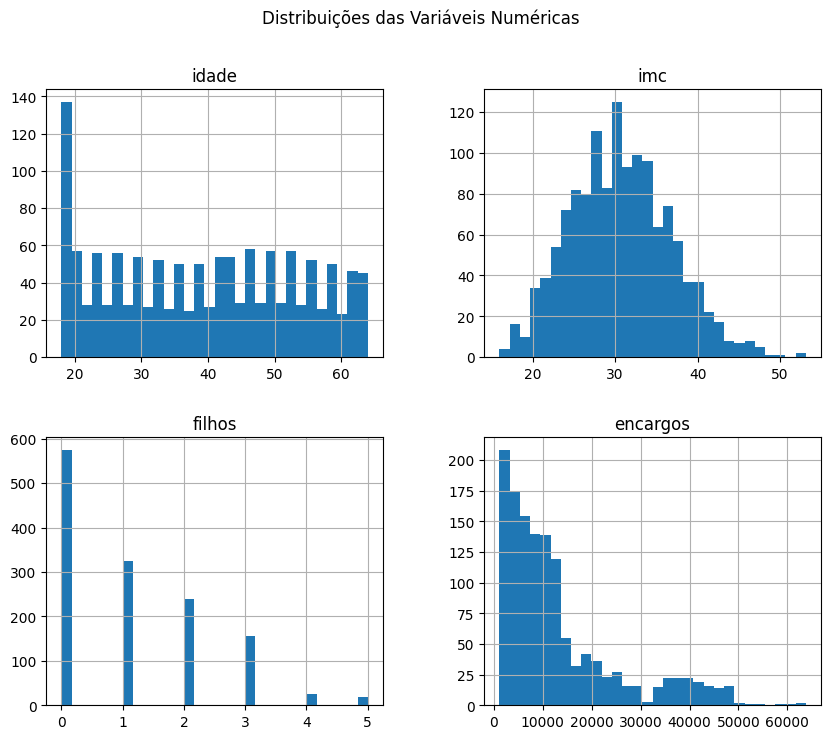

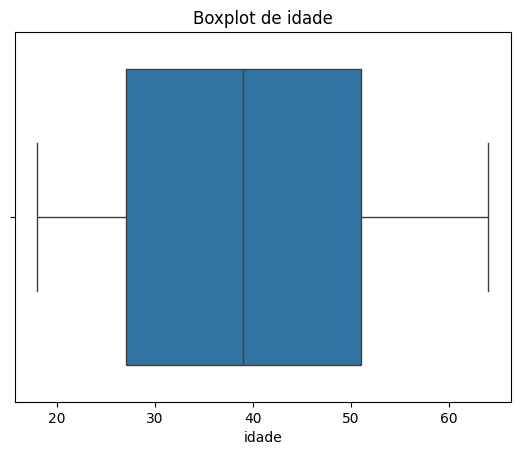

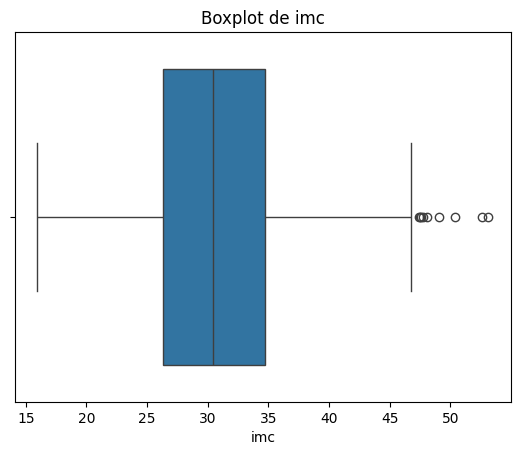

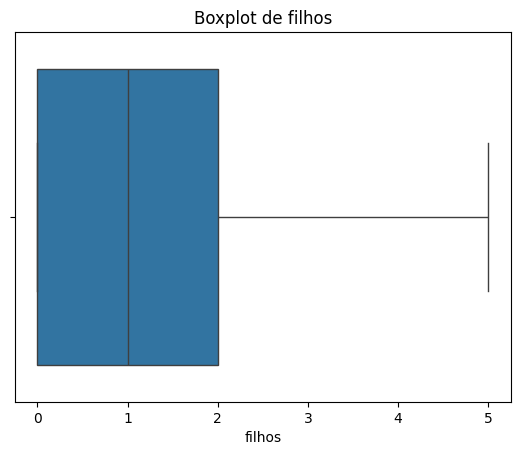

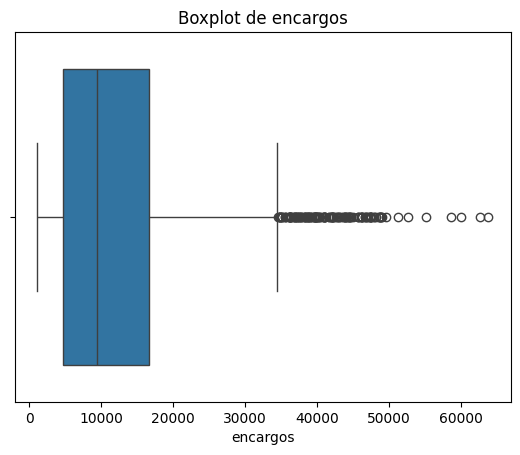

In [9]:
# Verificar novamente se há valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

# Histograma das variáveis numéricas
df[['idade', 'imc', 'filhos', 'encargos']].hist(bins=30, figsize=(10,8))
plt.suptitle("Distribuições das Variáveis Numéricas")
plt.show()

# Boxplots para detecção de outliers
for col in ['idade', 'imc', 'filhos', 'encargos']:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

## Interpretação da Análise Exploratória

- **Valores ausentes:** nenhuma coluna com dados faltantes — não precisamos fazer imputação ou remoção.

- **Distribuições:**
  - **Idade:** distribuição relativamente uniforme, mais concentrada entre 20 e 40 anos.
  - **IMC:** maioria entre 20 e 40, mas com alguns outliers acima de 45.
  - **Filhos:** maioria com até 2 filhos; poucos casos acima de 3.
  - **Encargos:** distribuição assimétrica — muitos valores baixos, mas com outliers claros acima de 40 mil.

- **Boxplots:**
  - Mostram presença de **outliers** importantes, principalmente em `imc` e `encargos`.
  - Decidimos **manter os outliers** por dois motivos: o dataset é pequeno (1338 entradas) e queremos testar a robustez do modelo.

**Resumo:**  
O dataset está **limpo e pronto** para o pré-processamento.  
A presença de outliers será um ponto importante na hora de avaliar a performance e a escolha do modelo.

##  4. Pré-processamento dos Dados

Agora precisamos preparar os dados para a modelagem:  
- Transformar variáveis **categóricas** em variáveis numéricas, usando **One-Hot Encoding**.  
- Separar as **variáveis preditoras** (`X`) e a **variável alvo** (`y`), que no nosso caso é `encargos`.


In [10]:
# Transformar variáveis categóricas em dummies
df = pd.get_dummies(df, columns=['genero', 'fumante', 'regiao'], drop_first=True)

print("Colunas após Encoding:")
print(df.columns)

# Separar variáveis preditoras (X) e alvo (y)
X = df.drop('encargos', axis=1)
y = df['encargos']

print("Variáveis preditoras (X):")
display(X.head())

print("Variável alvo (y):")
display(y.head())

Colunas após Encoding:
Index(['idade', 'imc', 'filhos', 'encargos', 'genero_masculino', 'fumante_sim',
       'regiao_noroeste', 'regiao_sudeste', 'regiao_sudoeste'],
      dtype='object')
Variáveis preditoras (X):


,idade,imc,filhos,genero_masculino,fumante_sim,regiao_noroeste,regiao_sudeste,regiao_sudoeste
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


Variável alvo (y):


0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: encargos, dtype: float64

## Comentários: Transformação das Variáveis Categóricas

Aplicamos **One-Hot Encoding** para transformar as variáveis categóricas (`genero`, `fumante`, `regiao`) em variáveis numéricas binárias.

### Por que fizemos isso?

- Modelos de regressão, como a Regressão Linear, **não entendem variáveis categóricas** — eles só operam com números.
- O **One-Hot Encoding** cria colunas binárias (`0` ou `1`) para representar as categorias, **sem atribuir ordens falsas** entre elas.
- Isso evita que o modelo interprete, por exemplo, que `masculino` vale mais ou menos que `feminino` só porque o número associado seria maior ou menor.
- Assim, garantimos que o modelo aprenda de forma **neutra e correta** o impacto de cada categoria na variável alvo.

---

### Sobre `drop_first=True`

- Mantivemos `drop_first=True` para **evitar multicolinearidade**.  
- Multicolinearidade acontece quando há colunas **redundantes**, ou seja, quando uma variável pode ser **determinada** pelas demais.
- No One-Hot Encoding, se mantivermos todas as categorias, uma delas será automaticamente dedutível pelas outras → gerando **multicolinearidade perfeita**.
- Isso pode:  
  Inflar os erros padrão,  
  Distorcer a interpretação dos coeficientes,  
  Prejudicar a estabilidade do modelo.
  
Por isso, ao usar `drop_first=True`, eliminamos uma categoria (de forma arbitrária), reduzimos o número de colunas e evitamos esse problema.

---

### O que mudou no dataset?

- Agora, as variáveis preditoras (`X`) estão todas **numéricas** e prontas para o modelo.
- A variável alvo (`y`) continua sendo `encargos`, o valor que queremos prever.

**Exemplo de variáveis transformadas:**
- `genero_masculino`: `True` se for masculino, `False` caso contrário.
- `fumante_sim`: `True` se for fumante.
- `regiao_*`: representa as regiões como variáveis binárias.


## 5. Divisão em Conjuntos de Treinamento e Teste

Agora vamos dividir o dataset para treinar e avaliar o modelo.  
Separar os dados evita que o modelo "decor" os exemplos e permite uma avaliação mais realista de sua capacidade de generalização.

Usaremos **80% dos dados para treino** e **20% para teste**.


In [11]:
from sklearn.model_selection import train_test_split

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Treinamento: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")


Treinamento: 1070 amostras
Teste: 268 amostras


## Comentário: Por que dividir o dataset?

Dividimos o dataset em dois conjuntos:

- **Treinamento (80%)** → para o modelo **aprender** os padrões a partir dos dados.
- **Teste (20%)** → para **avaliar** se o modelo consegue **generalizar** para dados que nunca viu.

Essa separação é essencial para evitar o **overfitting** — quando o modelo "decora" os dados de treino, mas falha ao prever novos casos.

Usamos `random_state=42` para garantir que a divisão seja **reprodutível** — ou seja, se rodarmos o código novamente, a divisão será a mesma.

**Resumo:**  
Separar os dados é um dos passos mais importantes para validar a **robustez** e a **eficácia** do modelo.


## 6. Modelagem Preditiva — Regressão Linear

Agora vamos criar e treinar o nosso modelo de **Regressão Linear**.

Optamos por começar com a Regressão Linear por ser um modelo **simples**, **interpretável** e ideal para estabelecer uma **linha de base**.

(Depois, podemos evoluir para modelos mais complexos).


In [12]:
from sklearn.linear_model import LinearRegression

# Inicializar o modelo
modelo = LinearRegression()

# Treinar o modelo com os dados de treino
modelo.fit(X_train, y_train)

print("Modelo treinado com sucesso!")


Modelo treinado com sucesso!


## Explicação do Código — Modelagem com Regressão Linear

- **`modelo = LinearRegression()`** → inicializamos o modelo de Regressão Linear usando a biblioteca **scikit-learn**.

- **`modelo.fit(X_train, y_train)`** → aqui o modelo **aprende** a relação entre as variáveis preditoras (`X_train`) e a variável alvo (`y_train`).

**Resumo:**  
Com essas duas linhas de código, o modelo está **pronto para fazer previsões** com base no que aprendeu a partir dos dados de treinamento.


## 7.Avaliação do Modelo

Agora vamos avaliar a performance do modelo com métricas estatísticas e visualizações.  

As principais métricas que vamos usar são:

- **MSE (Erro Quadrático Médio)** → quanto menor, melhor.
- **RMSE (Raiz do Erro Quadrático Médio)** → interpretação mais intuitiva, na mesma unidade da variável `encargos`.
- **R² (Coeficiente de Determinação)** → indica o quanto da variabilidade do `encargos` é explicada pelo modelo (varia de 0 a 1).

Também vamos visualizar um gráfico de **valores reais vs previstos**.

MSE: 33596915.85
RMSE: 5796.28
R²: 0.78


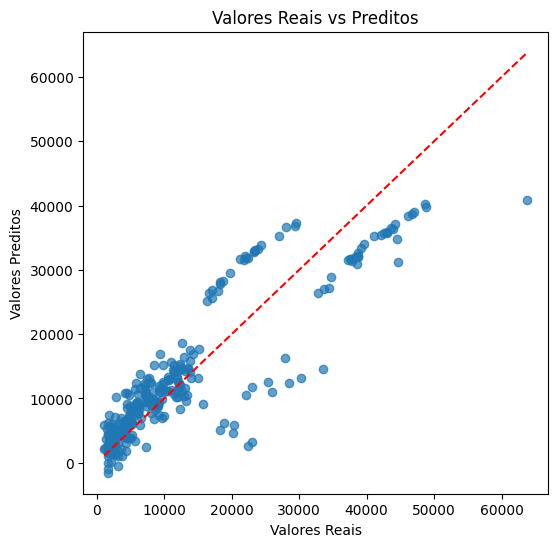

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Fazer previsões com os dados de teste
y_pred = modelo.predict(X_test)

# Cálculo das métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Gráfico: valores reais vs previstos
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # linha de referência
plt.show()


## Interpretação das Métricas de Avaliação

### MSE — Erro Quadrático Médio: `33.596.915,85`

- Mede o **erro médio ao quadrado** entre os valores previstos e os reais.
- Penaliza mais os **erros grandes**.
- Como os encargos chegam a mais de R$ 60 mil, faz sentido o MSE estar na casa dos **milhões**.
- **Não é muito intuitivo** de interpretar diretamente.

---

### RMSE — Raiz do Erro Quadrático Médio: `5.796,28`

- É a raiz quadrada do MSE e, por isso, fica na **mesma unidade** da variável `encargos`.
- Significa que, em média, o modelo **erra cerca de R$ 5.800** pra mais ou pra menos.
- Mais intuitivo para explicar a **precisão do modelo**.

---

### R² — Coeficiente de Determinação: `0.78`

- Mede o quanto da **variação dos custos médicos** o modelo consegue **explicar**.
- Varia entre **0 e 1**:  
  - **1** → modelo perfeito.  
  - **0** → modelo inútil.  
- Com **0.78**, significa que o modelo explica **78% da variação** nos encargos.

---

### **Resumo:**

Nosso modelo:  
- Tem um erro médio de cerca de **R$ 5.800**.  
- Explica **78%** dos fatores que influenciam os custos médicos.

É um resultado **satisfatório**, principalmente para um modelo **simples** e **sem ajustes mais avançados**.


## 8. Validação Estatística com `statsmodels`

Agora vamos usar o pacote **`statsmodels`** para fazer uma **validação estatística** mais completa.  
Diferente do `scikit-learn`, o `statsmodels` nos permite analisar:

- **p-valores** → verificar a **significância estatística** de cada variável.
- **intervalos de confiança** → entender a **precisão** dos coeficientes estimados.
- **resumo completo** do modelo → com várias estatísticas úteis para interpretação.

Isso é importante para validar a **robustez** do modelo e garantir que as variáveis realmente contribuem para explicar o `encargos`.


In [15]:
import statsmodels.api as sm

# Garantir que todas as variáveis são numéricas
X = X.astype(float)

# Adicionar a constante para o intercepto
X2 = sm.add_constant(X)

# Ajustar o modelo com statsmodels
modelo_stats = sm.OLS(y, X2).fit()

# Exibir o resumo estatístico
print(modelo_stats.summary())


                            OLS Regression Results                            
Dep. Variable:               encargos   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        00:11:49   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.194e+04    987.819  

## Resumo da Validação Estatística

Rodamos a validação com `statsmodels` e o que a gente viu?

- O modelo conseguiu explicar cerca de **75%** da variação nos custos médicos → isso é **bom** pra um modelo simples como a Regressão Linear.

- Algumas variáveis se mostraram **bem importantes**:
  - Ser **fumante** aumenta, em média, o custo médico em mais de **R$ 23 mil** → faz sentido, né?
  - Quanto maior o **IMC** e a **idade**, maior também o custo.
  - Ter **filhos** também aumenta um pouco o custo.

- Outras variáveis **não foram tão importantes**:
  - Por exemplo, o **gênero** (ser homem ou mulher) não teve um impacto estatisticamente significativo.
  - A **região noroeste** também não se destacou.

- No geral, o modelo tá **bem ajustado**, os testes mostraram que ele é **consistente** e a análise estatística só reforça o que a gente viu nas outras métricas.

**Resumo da ópera:**  
O modelo funciona bem, identifica variáveis-chave e ainda dá pra evoluir testando modelos mais complexos ou refinando as variáveis.


## Conclusão e Próximos Passos

Finalizamos nosso modelo de **Regressão Linear** para prever os **custos médicos** com base em características pessoais.

### 📝 O que conseguimos até aqui:

- Fizemos toda a **exploração dos dados**, identificando outliers e padrões.
- Transformamos variáveis categóricas com **One-Hot Encoding**.
- Treinamos um modelo de **Regressão Linear**.
- Avaliamos o desempenho → com um **R² de ~75%** → um bom resultado!
- Fizemos uma **validação estatística** completa, confirmando que variáveis como **fumante, idade e IMC** são as que mais impactam no custo.

---

### Próximos passos:

- Testar modelos mais **complexos** → como **Árvores de Decisão**, **Random Forest** ou **XGBoost**.
- Fazer **ajuste de hiperparâmetros** para melhorar a performance.
- Explorar **transformações nas variáveis** (ex.: aplicar log no `encargos` pra reduzir o impacto de outliers).
- Criar uma **API** para expor o modelo.
- Fazer um **deploy** e transformar isso em um serviço de previsão real.

---

### **Resumo final:**

Modelo rodou bem, resultado consistente e explicável.  
Deu pra aplicar na prática vários conceitos que vimos nas aulas:  
- Pré-processamento,  
- Modelagem,  
- Avaliação,  
- Validação estatística.  

**Missão cumprida!**
